# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [2]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf



In [3]:
# Import data from Yahoo finance

def get_data(symbol='AAPL', start_date='2020-01-01', end_date='2020-12-31'):
    '''
    Setup of an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then downloads the data from Yahoo Finance for the selected symbol(s) and time period and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for each symbol with the time period as index (ordered ascending)
    '''
    dates= pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    
    df_tmp = yf.download(symbol, start_date, end_date)
    df_tmp = df_tmp[['Adj Close']]
    df_tmp = df_tmp.rename(columns={"Adj Close": symbol})
        
    df = df.join(df_tmp)
    df = df.dropna()
    
    return df

In [17]:
data_analysis_df = get_data(symbol='AAPL', start_date='2019-01-01', end_date='2021-05-07')
data_analysis_df.head()

[*********************100%***********************]  1 of 1 completed


,AAPL
2019-01-02,38.439735
2019-01-03,34.610851
2019-01-04,36.088364
2019-01-07,36.008041
2019-01-08,36.694466


In [18]:
if data_analysis_df.shape[0] == 0:
    value = 1
else:
    value = 0
    
value

0

### 2. Normalize data and plot to check for anomalies

In [594]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [595]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [596]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Absolute stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

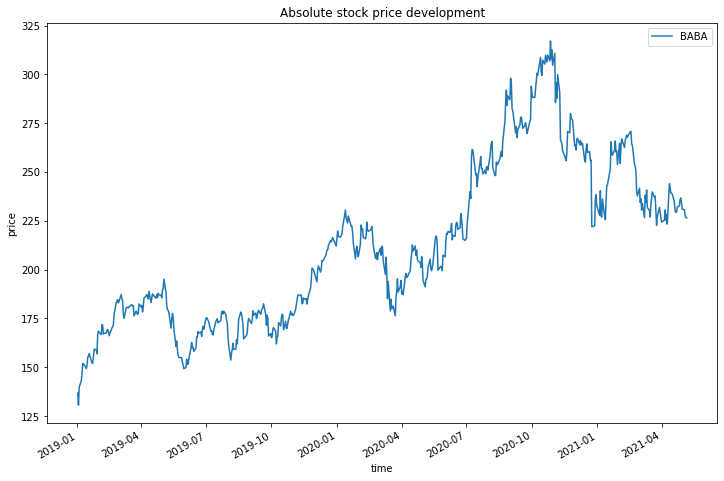

In [597]:
plot_stock_data(data_analysis_df)

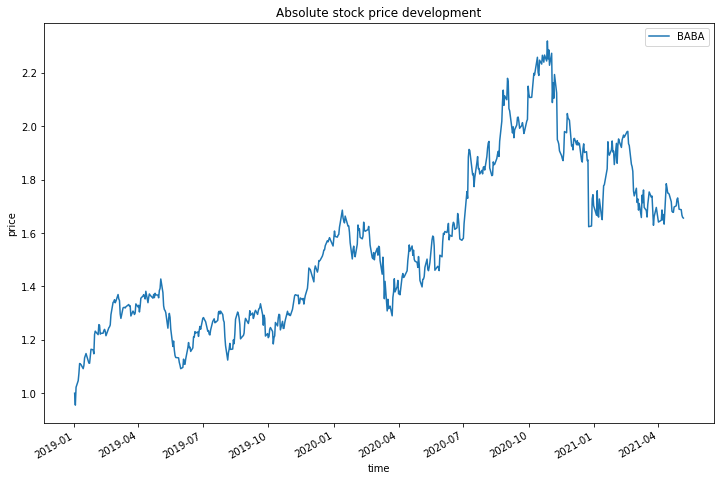

In [598]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [599]:
# Simple moving average (SMA)

win = 10
sma = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma.tail()
std_df.tail()

,BABA
2021-04-30,0.019839
2021-05-03,0.019409
2021-05-04,0.021264
2021-05-05,0.023892
2021-05-06,0.026452


In [600]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [601]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,BABA
2021-04-30,1.741214
2021-05-03,1.737378
2021-05-04,1.739639
2021-05-05,1.742950
2021-05-06,1.745924


In [602]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [603]:
daily_returns = get_daily_returns()
daily_returns.head()

,BABA
2019-01-02,0.000000
2019-01-03,-0.044623
2019-01-04,0.070061
2019-01-07,0.023971
2019-01-08,0.025786


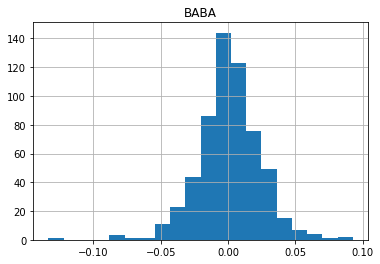

In [604]:
daily_returns.hist(bins= 20)
plt.show()

In [605]:
# Cumulative returns

def get_cumulative_returns(df=data_analysis_df):
    cumulative_returns = df.copy
    cumulative_returns= (df/df.iloc[0]) - 1
    return cumulative_returns

In [606]:
cumulative_returns = get_cumulative_returns()
cumulative_returns.head()

,BABA
2019-01-02,0.000000
2019-01-03,-0.044623
2019-01-04,0.022312
2019-01-07,0.046818
2019-01-08,0.073811


In [607]:
# Momentum

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [608]:
momentum = get_momentum()
momentum.tail()

,BABA
2021-04-30,-0.004869
2021-05-03,-0.008552
2021-05-04,-0.033995
2021-05-05,-0.041991
2021-05-06,-0.033137


In [609]:
# Get market index

market_index = get_data(symbol='SPY', start_date='2019-01-01', end_date='2021-05-07')
market_index.head(), market_index.tail()


[*********************100%***********************]  1 of 1 completed


(                   SPY
 2019-01-02  240.242630
 2019-01-03  234.509766
 2019-01-04  242.364868
 2019-01-07  244.275818
 2019-01-08  246.570862,
                    SPY
 2021-04-30  417.299988
 2021-05-03  418.200012
 2021-05-04  415.619995
 2021-05-05  415.750000
 2021-05-06  419.070007)

### 4. Merge all indicators and symbols into one datafrage

In [610]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
        df_temp = df_temp.join(sma[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(market_index['SPY'], on='Date').rename(columns={'SPY':'Market Index'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
        indicator_df.dropna()
    
    return indicator_df

In [611]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2019-01-02,BABA,136.699997,0.000000,0.000000,1.062195,0.000000,1.170765,0.953624,240.242630
1,2019-01-03,BABA,130.600006,-0.044623,-0.044623,1.062195,0.000000,1.170765,0.953624,234.509766
2,2019-01-04,BABA,139.750000,0.070061,0.022312,1.062195,0.000000,1.170765,0.953624,242.364868
3,2019-01-07,BABA,143.100006,0.023971,0.046818,1.062195,0.000000,1.170765,0.953624,244.275818
4,2019-01-08,BABA,146.789993,0.025786,0.073811,1.062195,0.000000,1.170765,0.953624,246.570862
...,...,...,...,...,...,...,...,...,...,...
586,2021-04-30,BABA,230.949997,-0.013793,0.689466,1.701536,-0.004869,1.741214,1.661858,417.299988
587,2021-05-03,BABA,230.710007,-0.001039,0.687710,1.698559,-0.008552,1.737378,1.659740,418.200012
588,2021-05-04,BABA,227.899994,-0.012180,0.667154,1.697110,-0.033995,1.739639,1.654582,415.619995
589,2021-05-05,BABA,226.779999,-0.004914,0.658961,1.695165,-0.041991,1.742950,1.647380,415.750000


In [612]:
indicator_model_df[indicator_model_df['Symbol']=='BABA'].describe()

,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,212.539087,0.001120,0.554785,1.550292,0.005388,1.633528,1.467055,312.980941
std,41.396094,0.023032,0.302824,0.301892,0.048904,0.323088,0.287078,44.177581
min,130.600006,-0.133422,-0.044623,1.062195,-0.160458,1.145031,0.953624,219.431061
25%,177.425003,-0.011126,0.297915,1.290552,-0.022691,1.346356,1.231613,279.861938
50%,206.970001,0.001194,0.514045,1.515201,0.008112,1.590757,1.417374,302.774231
75%,242.195000,0.014069,0.771726,1.776313,0.033699,1.914491,1.650120,338.426331
max,317.140015,0.092696,1.319971,2.263365,0.211299,2.379195,2.211089,420.059998


## II. MACHINE LEARNING PIPELINE 

### 1. Create train and test data and standardize

In [613]:
from sklearn import preprocessing

def create_train_test_data(indicator_df, symbol, train_size=0.8, start_pred='2021-05-07', end_pred='2021-05-14'):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        start_pred - str - start date of prediction
        end_pred - str - end date of prediction
        OUTPUT:
        pred_days - int - days to be predicted
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        X_predict = nd array - contains the data of the independent variable for the prediction period
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
        
    '''
    sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
    ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')
    
    try:
        if sd >= ed:
            raise ValueError('Start date beyound end date')
        else:
            pred_days = (ed-sd).days

            indicator_df = indicator_df[indicator_df['Date'] <= start_pred] 
            
            df = indicator_df.copy().drop(['Symbol','Date'], axis=1)
            
            for i in range(1,pred_days):
                indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))

        
            train_df = indicator_df.copy().iloc[pred_days:] # Training data starts from the date where data for all indicators is available
            
            if pred_days > 0:
                X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                X_predict = train_df.iloc[-pred_days:, 3:]
                Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe
                
                X.fillna(method='ffill', inplace=True)
                X.fillna(method='bfill', inplace=True)

                Y.fillna(method='ffill', inplace=True)
                Y.fillna(method='bfill', inplace=True)
                
            
            train_ct = int(X.shape[0] * train_size)
            test_ct = X.shape[0] - train_size

            X_train, X_test = X.iloc[:train_ct], X.iloc[train_ct:]  
            Y_train, Y_test = Y.iloc[:train_ct].copy().drop('Date', axis=1), Y.iloc[train_ct:].copy().drop('Date', axis=1)

            time_series_train = Y.iloc[:train_ct].Date
            time_series_test = Y.iloc[train_ct:].Date   


            return pred_days, preprocessing.scale(X_train), Y_train['Adj Close'].tolist(), preprocessing.scale(X_test), Y_test['Adj Close'].tolist(), time_series_train, time_series_test, preprocessing.scale(X_predict)
        
    
    except ValueError:
        raise
        

In [614]:
pred_days, X_train, Y_train, X_test, Y_test, time_series_train, time_series_test, X_predict   = create_train_test_data(indicator_model_df, symbol='AAPL', train_size=0.8)



In [615]:
pred_days, len(X_train), len(Y_train),  len(time_series_train)

(7, 461, 461, 461)

In [616]:
len(X_test), len(Y_test),len(time_series_test)

(116, 116, 116)

In [617]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([-9.63317158e-18,  0.00000000e+00,  1.35635056e-15,  5.00924922e-17,
        -4.93218385e-16,  1.23304596e-16,  8.01479875e-16,  2.46609192e-16,
         1.92663432e-18, -1.84956894e-16,  6.16522981e-16, -3.85326863e-17,
        -6.16522981e-16, -2.46609192e-16, -3.69913789e-16,  6.16522981e-17,
        -9.63317158e-18, -1.23304596e-16,  4.93218385e-16,  0.00000000e+00,
         8.01479875e-16,  3.69913789e-16,  1.84956894e-16, -1.84956894e-16,
        -2.50462461e-17,  0.00000000e+00, -5.54870683e-16, -1.15598059e-17,
        -1.23304596e-16,  3.69913789e-16,  2.46609192e-16,  6.16522981e-17,
         7.70653726e-18, -1.84956894e-16,  4.31566087e-16, -3.85326863e-17,
        -2.46609192e-16, -6.16522981e-16,  6.16522981e-16, -2.46609192e-16,
        -2.88995147e-17,  1.23304596e-16,  0.00000000e+00,  2.31196118e-17,
        -1.84956894e-16,  2.46609192e-16,  6.16522981e-16, -1.84956894e-16,
         1.54130745e-17, -2.46609192e-16,  6.16522981e-17,  7.32121040e-17,
         8.6

### 2. Setup and validate different models

In [618]:
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [619]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, Y_future, time_series_test):
    ''' '''
    
    rmse = np.sqrt(np.sum((Y_test - Y_predict) **2)/len(Y_predict)) #(root mean squared error)
    mse = mean_squared_error(Y_test, Y_predict)
    corr = np.corrcoef(Y_test, Y_predict)
    corrcoef = corr[0,1]
    mae = mean_absolute_error(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    
    fig = plt.figure(figsize=(12,8))
    
    value_days = len(Y_future)
    end_date = (time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

    time_series_future = pd.date_range(time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')
    
    plt.plot(time_series_future , Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')
    
    plt.legend()
    
    return print(('RMSE {} \n MSE {} \n MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(rmse, mse, mae, mape, r2 , corrcoef))

In [620]:
# Lasso Regression

lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, Y_train)
Y_lasso_predict = lasso.predict(X_test)
Y_lasso_future = lasso.predict(X_predict)

RMSE 48.64441786075314 
 MSE 2366.279389011559 
 MAE 41.64482479516068 
 MAPE 0.17181198967984376 
 r2 -7.881137611222421 
 CORRCOEF 0.657679352039476 



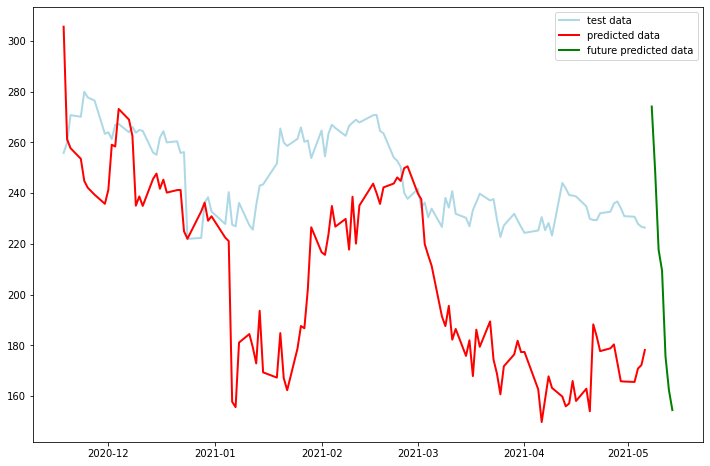

In [621]:
evaluate_model_performance(Y_test, Y_lasso_predict, Y_lasso_future, time_series_test)

In [622]:
# Lasso LARS

lassolars = linear_model.LassoLars(alpha = 0.1)
lassolars.fit(X_train, Y_train)
Y_lassolars_predict = lassolars.predict(X_test)
Y_lassolars_future = lassolars.predict(X_predict)

RMSE 48.81256404107789 
 MSE 2382.6664082643306 
 MAE 41.726217340854205 
 MAPE 0.17212021431696992 
 r2 -7.942641495209006 
 CORRCOEF 0.6484442501316201 



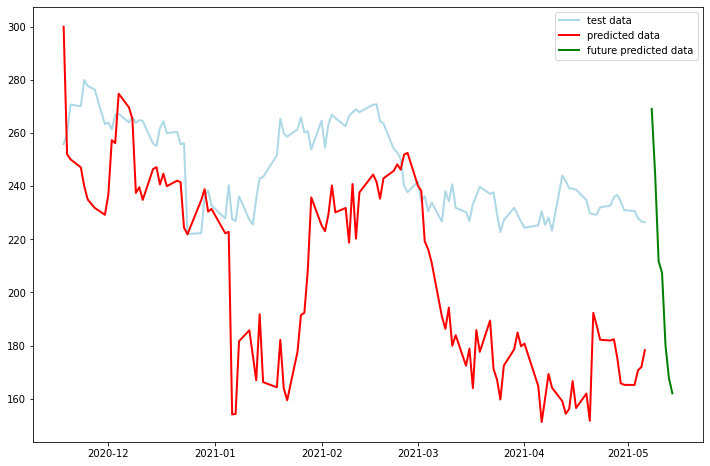

In [623]:
evaluate_model_performance(Y_test, Y_lassolars_predict, Y_lassolars_future, time_series_test)

In [624]:
Y_lassolars_future

array([269.12380883, 244.26578848, 211.8016632 , 207.36588834,
       180.1619003 , 167.76793052, 162.0217006 ])

In [625]:
# knn
knn = KNeighborsRegressor(n_neighbors=4)  #weights='distance'
knn.fit(X_train, Y_train)
Y_knn_predict = knn.predict(X_test)
Y_knn_future = knn.predict(X_predict)

RMSE 49.212567489610855 
 MSE 2421.8767989195035 
 MAE 44.39913723386567 
 MAPE 0.17969889110290058 
 r2 -8.089806228509515 
 CORRCOEF 0.38731998860089806 



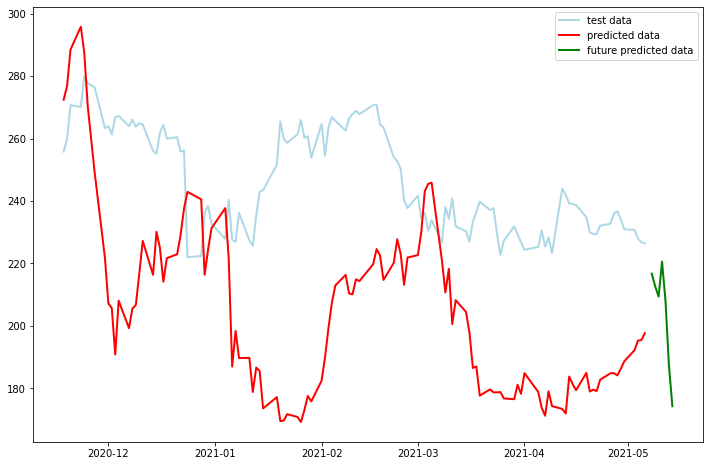

In [626]:
evaluate_model_performance(Y_test, Y_knn_predict, Y_knn_future, time_series_test)

In [627]:
# AdaBoost
AdaBoost = AdaBoostRegressor(base_estimator=knn, random_state=42)
AdaBoost.fit(X_train, Y_train)
Y_AdaBoost_predict = AdaBoost.predict(X_test)
Y_AdaBoost_future = AdaBoost.predict(X_predict)

RMSE 48.87108703826836 
 MSE 2388.3831483020012 
 MAE 43.56594769708042 
 MAPE 0.17665586271729433 
 r2 -7.96409760694201 
 CORRCOEF 0.3736052805245747 



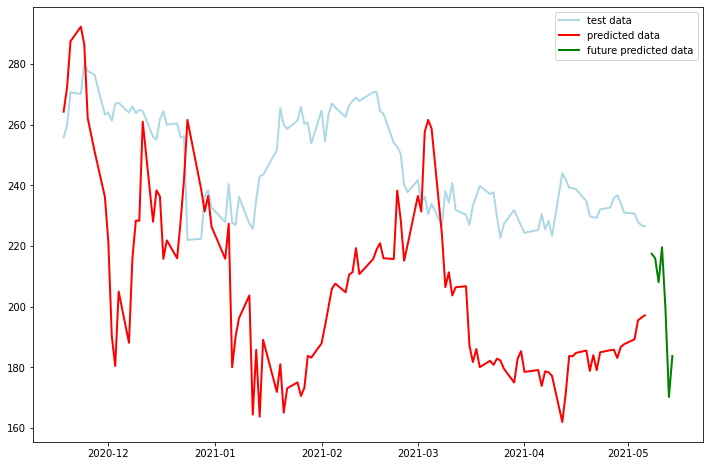

In [628]:
evaluate_model_performance(Y_test, Y_AdaBoost_predict, Y_AdaBoost_future, time_series_test)

In [629]:
# Support Vector Regression
supportvector = SVR(kernel='poly', verbose=True, degree=3, max_iter=1000000)
supportvector.fit(X_train, Y_train)
Y_supportvector_predict = supportvector.predict(X_test)
Y_supportvector_future = supportvector.predict(X_predict)

[LibSVM]

RMSE 54.76703180775303 
 MSE 2999.427773031432 
 MAE 52.58197512085297 
 MAPE 0.2106434206209628 
 r2 -10.257474891137816 
 CORRCOEF 0.38639472436793393 



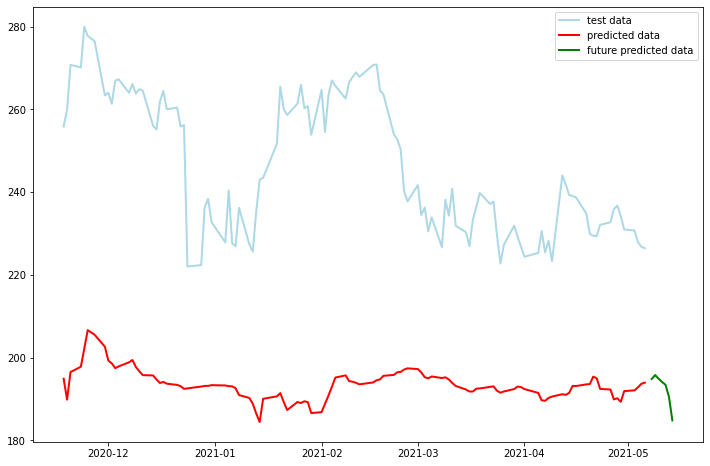

In [630]:
evaluate_model_performance(Y_test, Y_supportvector_predict, Y_supportvector_future,time_series_test)

In [631]:
# Random Forest Regression
randomforest = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=50, min_samples_split=8)
randomforest.fit(X_train, Y_train)
Y_randomforest_predict = randomforest.predict(X_test)
Y_randomforest_future = randomforest.predict(X_predict)

RMSE 49.34103192507867 
 MSE 2434.5374314316323 
 MAE 41.652386770577266 
 MAPE 0.171139398802699 
 r2 -8.137324209736702 
 CORRCOEF 0.5413828785855298 



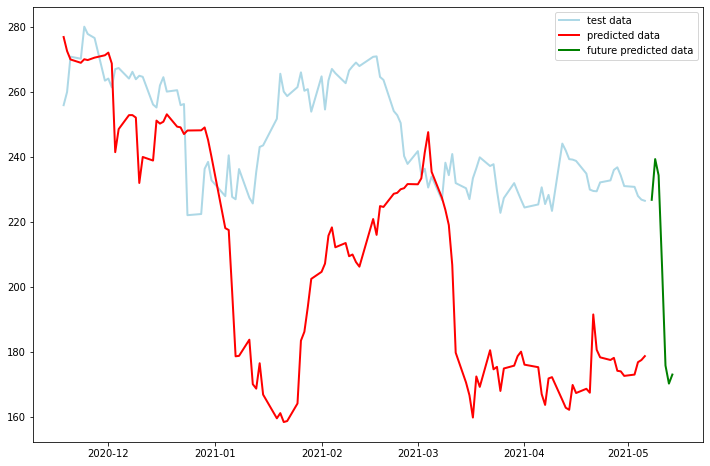

In [632]:
evaluate_model_performance(Y_test, Y_randomforest_predict, Y_randomforest_future, time_series_test)

### 3. Put all the above into one class

In [674]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbol='AAPL', start_date='2020-01-01', end_date='2021-04-16'):
        ''' Create an instance of StockDataAnalysis'''
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = get_data(self.symbol, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price development')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=10):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.b_upper_band = self.sma + self.rstd*2
        self.b_lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        

    def calculate_cumulative_returns(self):
        cumulative_returns = self.data.copy
        cumulative_returns= (self.data/self.data.iloc[0]) - 1
        self.cumulative_returns = cumulative_returns
        
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
    
    def get_market_index(self, market_ix='SPY'):
        self.market_ix = market_ix
        self.market_index = get_data(symbol=market_ix, start_date=self.start_date, end_date=self.end_date)
        
    def setup_features(self, market_ix='SPY'):
        self.calculate_rolling_stats()
        self.calculate_bollinger_bands()
        self.calculate_daily_returns()
        self.calculate_cumulative_returns()
        self.calculate_momentum()
        self.get_market_index(market_ix=market_ix)
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            object 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
            df_temp = df_temp.join(self.b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.market_index[self.market_ix], on='Date').rename(columns={self.market_ix:'Market Index'})                   

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)
            self.indicator_df.dropna()

        return self.indicator_df

In [722]:
st_data = StockDataAnalysis('BABA','2018-01-01','2019-05-10')

[*********************100%***********************]  1 of 1 completed


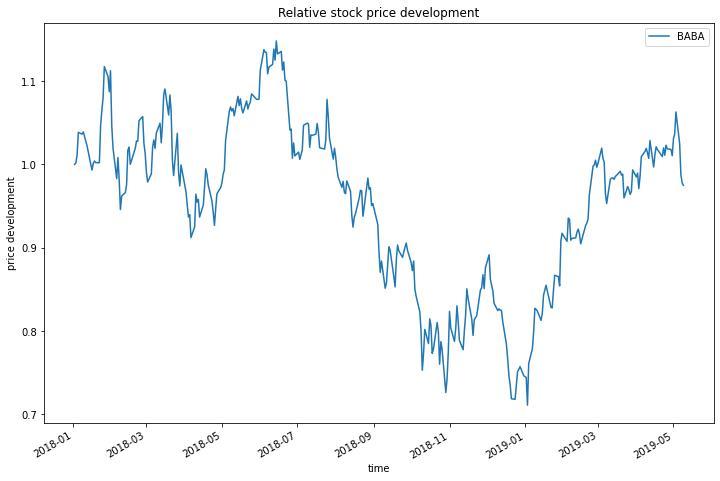

In [723]:
st_data.plot_stock_data()

In [724]:
st_data.setup_features()

[*********************100%***********************]  1 of 1 completed


In [725]:
st_data.calculate_rolling_stats()

In [726]:
st_data.calculate_bollinger_bands()

In [727]:
st_data.calculate_daily_returns()

In [728]:
st_data.calculate_momentum()

In [729]:
st_data.calculate_cumulative_returns()

In [730]:
st_data.get_market_index()

[*********************100%***********************]  1 of 1 completed


In [731]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2018-01-02,BABA,183.649994,0.000000,0.000000,1.020376,0.000000,1.055232,0.985519,253.283142
1,2018-01-03,BABA,184.000000,0.001906,0.001906,1.020376,0.000000,1.055232,0.985519,254.885162
2,2018-01-04,BABA,185.710007,0.009294,0.011217,1.020376,0.000000,1.055232,0.985519,255.959488
3,2018-01-05,BABA,190.699997,0.026870,0.038388,1.020376,0.000000,1.055232,0.985519,257.665283
4,2018-01-08,BABA,190.330002,-0.001940,0.036374,1.020376,0.000000,1.055232,0.985519,258.136414
...,...,...,...,...,...,...,...,...,...,...
335,2019-05-03,BABA,195.210007,0.025316,0.062946,1.024084,0.043402,1.056558,0.991610,283.594574
336,2019-05-06,BABA,188.240005,-0.035705,0.024993,1.025641,0.006954,1.056440,0.994842,282.427521
337,2019-05-07,BABA,181.429993,-0.036177,-0.012088,1.022450,-0.022310,1.061450,0.983451,277.711029
338,2019-05-08,BABA,179.589996,-0.010142,-0.022107,1.019140,-0.051344,1.067060,0.971219,277.325256


In [732]:
class ModelStockPrice():
    def __init__(self, start_predict=None, end_predict=None):
        '''Create an instance of the model to predict stockprice'''
        
        self.start_predict = start_predict
        self.end_predict = end_predict
        
        self.model = linear_model.LassoLars(alpha = 0.1)


    def create_train_test_data(self, stockdata, train_size=0.8, start_pred='2019-05-10', end_pred='2019-05-17'):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            start_pred - str - start date of prediction
            end_pred - str - end date of prediction
            OUTPUT:
            pred_days - int - days to be predicted
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            X_predict = nd array - contains the data of the independent variable for the prediction period
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
            time_series_test - 1d array - predicted time period

        '''
        sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
        ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')

        try:
            if sd >= ed:
                raise ValueError('Start date beyound end date')
            else:
                self.pred_days = (ed-sd).days

                indicator_df = stockdata.indicator_df[stockdata.indicator_df['Date'] <= start_pred] 

                df = stockdata.indicator_df.copy().drop(['Symbol','Date'], axis=1)

                for i in range(1, self.pred_days):
                    indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))


                train_df = indicator_df.copy().iloc[self.pred_days:] # Training data starts from the date where data for all indicators is available

                if self.pred_days > 0:
                    X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                    self.X_predict = preprocessing.scale(train_df.iloc[-pred_days:, 3:])
                    Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe

                    X.fillna(method='ffill', inplace=True)
                    X.fillna(method='bfill', inplace=True)

                    Y.fillna(method='ffill', inplace=True)
                    Y.fillna(method='bfill', inplace=True)


                train_ct = int(X.shape[0] * train_size)
                test_ct = X.shape[0] - train_size

                self.X_train, self.X_test = preprocessing.scale(X.iloc[:train_ct]), preprocessing.scale(X.iloc[train_ct:])  
                self.Y_train, self.Y_test = Y.iloc[:train_ct]['Adj Close'].copy().tolist(), Y.iloc[train_ct:]['Adj Close'].copy().tolist()

                self.time_series_train = Y.iloc[:train_ct].Date
                self.time_series_test = Y.iloc[train_ct:].Date   


                return self.pred_days, self.X_train, self.Y_train, self.X_test, self.Y_test, self.time_series_train, self.time_series_test, X_predict


        except ValueError:
            raise

            
    def fit(self):
        '''Fit the model with training data '''
        self.model.fit(self.X_train, self.Y_train)

    def predict(self):
        '''Predict stockprice '''
        self.Y_predict = self.model.predict(self.X_test)
        self.Y_future = self.model.predict(self.X_predict)
        return self.Y_predict, self.Y_future
    
    def evaluate_model_performance(self):
        '''Evaluate prediction'''

        rmse = np.sqrt(np.sum((self.Y_test - self.Y_predict) **2)/len(self.Y_predict)) #(root mean squared error)
        mse = mean_squared_error(self.Y_test, self.Y_predict)
        corr = np.corrcoef(self.Y_test, self.Y_predict)
        corrcoef = corr[0,1]
        mae = mean_absolute_error(self.Y_test, self.Y_predict)
        mape = mean_absolute_percentage_error(self.Y_test, self.Y_predict)
        r2 = r2_score(self.Y_test, self.Y_predict)

        fig = plt.figure(figsize=(12,8))

        value_days = len(self.Y_future)
        end_date = (self.time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

        time_series_future = pd.date_range(self.time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

        plt.plot(self.time_series_test, self.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(self.time_series_test, self.Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')

        plt.plot(time_series_future , self.Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')

        plt.legend()

        return print(('RMSE {} \n MSE {} \n MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(rmse, mse, mae, mape, r2 , corrcoef))
    

In [733]:
price_reg = ModelStockPrice()

In [734]:
price_reg.create_train_test_data(st_data)

(7,
 array([[-0.21688371,  0.7275539 ,  0.65418064, ...,  0.45411267,
          0.75447639, -0.49333481],
        [-0.19976668,  0.68054547,  0.65418064, ...,  0.45411267,
          0.75447639, -0.38527909],
        [-1.22685407,  0.41661463,  0.65418064, ...,  0.45411267,
          0.75447639, -0.2137101 ],
        ...,
        [-1.3274464 , -1.0646301 , -1.13074384, ..., -1.39360156,
         -1.87017729, -1.11613126],
        [-0.01286604, -1.07050587, -1.10417806, ..., -1.32819992,
         -1.83278054, -1.26873559],
        [ 1.11707423, -0.88296306, -1.08420303, ..., -1.2689387 ,
         -1.75346412, -0.98380992]]),
 [192.27999877929688,
  195.52999877929688,
  198.3300018310547,
  205.22000122070312,
  203.00999450683594,
  199.66000366210938,
  204.2899932861328,
  192.22000122070312,
  187.30999755859375,
  180.52999877929688,
  185.1699981689453,
  180.3000030517578,
  173.6999969482422,
  176.6699981689453,
  177.44000244140625,
  179.25,
  186.75999450683594,
  187.4499969

In [735]:
price_reg.fit()

In [736]:
Y_predict, Y_future_predict = price_reg.predict()
Y_future_predict

array([182.33262099, 184.84167118, 195.03007606, 176.12982452,
       159.24678751, 152.85458139, 162.7624371 ])

RMSE 12.723945018872318 
 MSE 161.89877684328565 
 MAE 9.339322945688902 
 MAPE 0.05236716756412258 
 r2 -2.695406322428157 
 CORRCOEF 0.680260619683674 



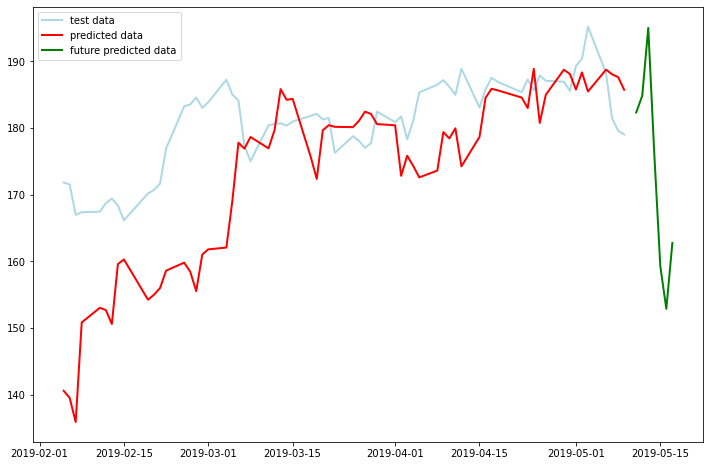

In [737]:
price_reg.evaluate_model_performance()